*AGEC 652 - Spring 2022*
# Structural estimation of a single-agent model
## Consumption and taxed labor supply

## Agenda

- You will estimate a model that is analytically simple, but with an econometric challenge that is complex enough to need the **Method of Simulated Moments (MSM)**
    - First, you will program the solution for the model for any given value of the parameters (inner loop)
    - Then, you will use optimization methods to search for the MSM estimates
    - As we will see, MSM is just like Method of Moments, but with numerical integration to calculate the sample moments
- The data used in this tutorial is synthetic: I generated it using numerical optimization with parameters that you will estimate

## Research problem

Question: **How do changes in income tax affect consumption?**

We have data from a random sample of workers in a specific industry. For each individual, we observe:
- Consumption level: $c_i$
- Number of hours worked: $b_i$
- Wage level: $w_i$

Individuals are subject to a tax level $\tau$ we do not observe

We want to estimate $E\left[\frac{\partial c}{\partial \tau}\right]$

## Model: theory

Individuals derive utility from consumption $c_i \ge 0$ and leisure $0 \le l_i \le 1$
- We calculate $l_i$ using data on hours worked and normalize between 0 (no leisure = maximum hours of work allowed) and 1 (no work)

$$U(c_i, l_i) = c_i^\gamma l_i^{(1-\gamma)}$$
where $0 \le \gamma \le 1$ is the relative preference for consumption over leasure

The budget constraint is
$$c_i \le (1-\tau)w_i(1-l_i) + \epsilon_i$$
where $\epsilon_i$ represents other income not observed in the wage data

## Model: theory

Given $(w_i, \epsilon_i, \gamma, \tau)$, each agent solves
$$\max_{c_i, l_i} U(c_i, l_i) = c_i^\gamma l_i^{(1-\gamma)} \\
s.t. c_i \le (1-\tau)w_i(1-l_i) + \epsilon_i$$

**Your turn, part 1**: 
Program function `solve_c_l(w, e, gamma, tau)` that solves the individual problem given model parameters and returns the solution vector  `[c, l]`

Steps:
1. Create the model with solver `Ipopt`
2. With `@variable`, declare variables `c` and `l` and their limits
3. With `@NLobjective`, declare the objective function
4. With `@NLconstraint`, declare the budget constraint
5. Solve (`optimize!(model)`) and return values of `c` and `l`

In [1]:
using JuMP, Ipopt
function solve_c_l(w, e, gamma, tau)
    model = Model(Ipopt.Optimizer)
    # Declare variables
    @variable(model, c >= 0)
    @variable(model, 0 <= l <= 1)
    # Declare objective
    @NLobjective(model, Max, c^gamma * l^(1-gamma))
    # Declare budget constraint
    @NLconstraint(model, c <= (1-tau)*w*(1-l) + e)
    set_silent(model) # Mute output
    optimize!(model)
    # Warn if error
    if (termination_status(model) != LOCALLY_SOLVED)
        println("Error: row $i, draw $j $(termination_status(model))")
    end
    c = value(c)
    l = value(l)
    return (c, l)
end

solve_c_l (generic function with 1 method)

Testing this function

In [2]:
solve_c_l(80.0, 2.0, 0.5, 0.1)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



(37.00000000623763, 0.513888888350326)

## Model: statistical assumptions

We assume that the unobserved portion of the income $\epsilon_i$ is uncorrelated with wage rate $w_i$: $E[\epsilon_i | w_i] = 0$
- This assumption is generally unrealistic. In practice, we'd expect some correlation here because high-wage agents usually have higher non-labor income. But let's keep it simple for the sake of the exercise

We will also assume that $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$
- To make estimation simpler, assume that we know that $\sigma^2 = 1$

## Estimation problem

We want to
1. Calculate parameters $\gamma$, $\tau$, and $\sigma^2$ from data $(c_i, l_i, w_i)_{i=1}^N$
2. Use those parameters to calculate policy-relevant parameter $\bar{\psi} \equiv \frac{1}{N} \sum_{i=1}^{N} \psi (w_i)$ where

$$\psi(w_i) \equiv E_\epsilon\left[\frac{\partial}{\partial \tau}C(w_i, \epsilon; \gamma, \tau)\right]$$

## Moment conditions


We have two parameters to estimate, so we need at least two moment conditions. What could those be?

- Model predictions match observations on average

\begin{equation}
m(\gamma, \tau) =
    \begin{bmatrix}
        \frac{1}{N}\sum_{i=1}^N \left(\hat{C}(w_i, e_i, \gamma, \tau) - c_i\right) \\
        \frac{1}{N}\sum_{i=1}^N \left(\hat{L}(w_i, e_i, \gamma, \tau) - l_i\right)
    \end{bmatrix} = 0
\end{equation}

- Technically, we are interacting residuals with a vector of ones. Since we assumed $w_i$ is exogenous, we could also form 2 other moment conditions: $\frac{1}{N}\sum_{i=1}^N w_i\left(\hat{C}_i - c_i\right)$ and $\frac{1}{N}\sum_{i=1}^N w_i\left(\hat{L}_i - l_i\right)$

But there's a problem: we don't observe $\epsilon_i$!

- We can use $\epsilon$'s distribution to calculate expected values $\Rightarrow$ simulated moments

## Simulated moment conditions

Instead, we use simulated moment conditions:
\begin{equation}
\hat{m}(\gamma, \tau) = E_\epsilon
    \begin{bmatrix}
        \frac{1}{N}\sum_{i=1}^N \left(\hat{C}(w_i, e_i, \gamma, \tau) - c_i\right) \\
        \frac{1}{N}\sum_{i=1}^N \left(\hat{L}(w_i, e_i, \gamma, \tau) - l_i\right)
    \end{bmatrix} = 0
\end{equation} 

The "simulated" part comes from drawing many values from the distribution of $\epsilon_i$ and taking the mean: it's just Monte Carlo integration
- Turns out this numerical integration method has well-defined asymptotics

**Your turn, part 2**: 
Program function `solve_Ec_El(w, gamma, tau, R)` that draws `R` values from the distribution of $\epsilon$, calculates `c` and `l` for each draw, then returns the average value of `c`s and `l`s

You can do that by modifying the code for `solve_c_l`
1. Declare the model as before, but now declare `e` as a model parameter with `@NLparameter` before you set the objective function
2. Draw R observations from N(0.0, 1.0) and store in `es`
3. Create a `for` loop over R observations
    - Set $\epsilon$: `set_value(e, es[i])`
    - Solve the model and store solutions in vectors `cs` and `ls`
4. Return means of `cs` and `ls`

In [3]:
using Random, Distributions
function solve_Ec_El(w, gamma, tau, R)
    model = Model(Ipopt.Optimizer)
    # Declare variables
    @variable(model, c >= 0)
    @variable(model, 0 <= l <= 1)
    # Declare objective
    @NLobjective(model, Max, c^gamma * l^(1-gamma))
    # Declare epsilon as model parameters
    @NLparameter(model, e == 0.0)
    # Declare budget constraint
    @NLconstraint(model, c <= (1-tau)*w*(1-l) + e)
    set_silent(model) # Mute output
    # Draw R epsilons
    es = rand(Normal(0.0, 1.0), R)
    # Vectors to store for individual i
    cs_i = zeros(R); ls_i = zeros(R)
    # Loop to simulate
    for i in 1:R
        set_value(e, es[i]) # Set a drawn value for epsilon
        optimize!(model)
        # Warn if error
        if (termination_status(model) != LOCALLY_SOLVED)
            println("Error in draw $i: $(termination_status(model))")
        end
        cs_i[i] = value(c)
        ls_i[i] = value(l)
    end
    # Take average of simulated values
    Ec = mean(cs_i); El = mean(ls_i)
    return (Ec, El)
end

solve_Ec_El (generic function with 1 method)

In [6]:
solve_Ec_El(80.0, 0.5, 0.1, 10)

(35.88891400857791, 0.498457138419941)

In [5]:
solve_Ec_El(80.0, 0.5, 0.1, 10)

(36.115477712468525, 0.501603856522182)

## Data
Let's now take a look at our data set

In [7]:
using DataFrames, CSV
df = CSV.read("labor_supply.csv", DataFrame)

,ID,wage_rate,consump,labor_hours
,Int64,Float64,Float64,Int64
1,1,17.56,27927.5,1792
2,2,17.64,27664.9,1818
3,3,15.42,24129.7,1822
4,4,23.45,36110.5,1850
5,5,22.08,34183.1,1841
6,6,24.55,38780.5,1805
7,7,18.03,28605.0,1797
8,8,20.98,33028.6,1811
9,9,25.07,39672.7,1802


## Data

We need to make a few adjustments with the data so that we can use it in the model. First, we want to calculate leisure as a variable between 0 and 1. To do that, we consider that the maximum labor hours per year is 3,600 (twice the US average)

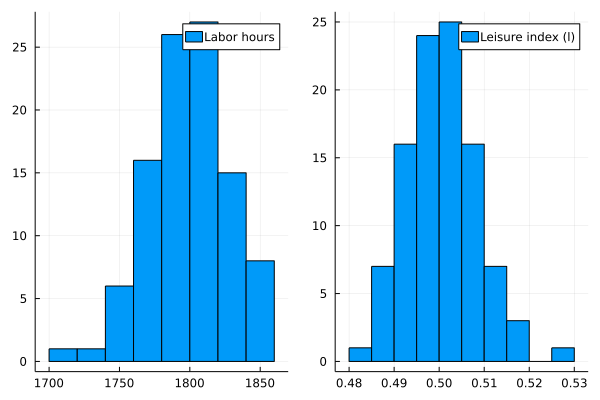

In [9]:
using Plots
df.l = 1 .- (df.labor_hours ./ 3600)
plot(histogram(df.labor_hours, label="Labor hours"),  histogram(df.l, label="Leisure index (l)"))

## Data

Next, we need to convert hourly wage rates to annual wage rates (when $l=0$). So we multiply the wage rate by 3600 hours. But to keep things scaled, we represent that in thousands of dollars

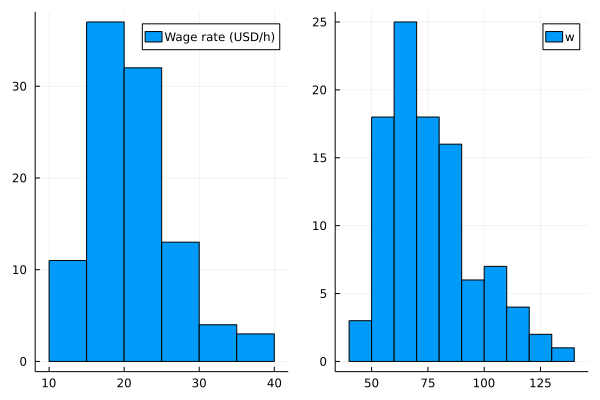

In [10]:
df.w = df.wage_rate .* 3.6
plot(histogram(df.wage_rate, label="Wage rate (USD/h)"),  histogram(df.w, label="w"))

## Data

Finally, we divide total consumption in dollars by 1,000, so we keep units consistent

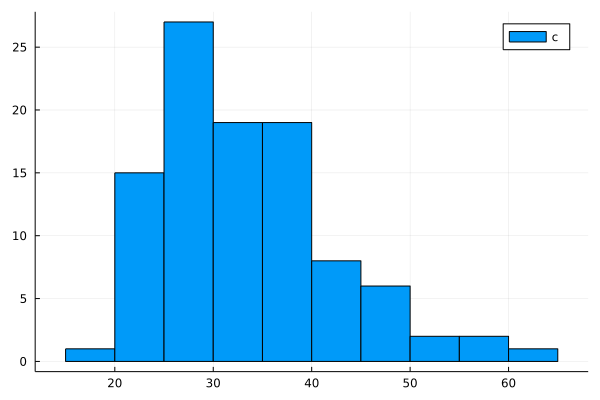

In [11]:
df.c = df.consump ./ 1000
histogram(df.c, label="c")

## Estimation: preliminaries

Since we will need to compute simulated moments, it is a good idea to start with a function that calculates $E[\hat{C}(w_i, e_i, \gamma, \tau)]$ and $E[\hat{L}(w_i, e_i, \gamma, \tau)]$ for all observations

**Your turn, part 3**: 
Program function `solve_all_Ec_El(gamma, tau)`, which loops over all observations in the data set, applies `solve_Ec_El(w, gamma, tau, R)` for each and stores it in a vector. Then, it returns the vectors of `cs` and `ls`
- Use `R = 20` for this example. This is much smaller than you'd use for an actual problem, but we want to have a solution before the end of the semester!

In [12]:
N = nrow(df)
function solve_all_Ec_El(gamma, tau)
    # Vectors to store simulated moments    
    cs = zeros(N)
    ls = zeros(N)
    # Number of MC draws
    R = 20 # Should be more, but we need to solve it before 10 AM!
    # Loop over individuals
    for i in 1:N
        cs[i], ls[i] = solve_Ec_El(df.w[i], gamma, tau, R)
    end
    return (cs, ls)
end

solve_all_Ec_El (generic function with 1 method)

In [13]:
@time solve_all_Ec_El(0.4, 0.1)

  9.560192 seconds (1.27 M allocations: 69.567 MiB, 0.10% compilation time)


([22.809678213973324, 22.762862225235374, 19.905273142892163, 30.35602105838056, 28.410749491106838, 31.86417433665908, 23.282850522845216, 27.38589177579676, 32.495404469665566, 21.32178022875484  …  26.91488104479212, 25.1481469680677, 19.33562088528444, 28.665133017067312, 42.36990440524024, 37.418504465619364, 36.32833781207471, 23.917278814836244, 23.48053818558538, 30.673884119218418], [0.6013688027170419, 0.5974128178664453, 0.5976267315993915, 0.599305476000657, 0.595703112569758, 0.6008933817185136, 0.5978423421876962, 0.6043209514501098, 0.6000865055230123, 0.6004376227063115  …  0.5950617496999568, 0.6001371441749659, 0.6015911494953401, 0.5999500395972288, 0.6020778524841972, 0.5996324558965271, 0.6004525122290275, 0.5995026654487431, 0.5982729496716688, 0.6007137155796765])

## Extra: parallel processing

Optimization problems are independent across observations, so we can solve then separately. This is a great case for parallel processing. 

We won't have time to cover the details, which you can read here https://docs.julialang.org/en/v1/manual/multi-threading/

But just for the sake of demonstration, I will define a version of the previous function that runs on multiple cores
- You need to set your Julia environment to run with multiple threads. On my laptop, I set it to use all 8 cores

In [14]:
Threads.nthreads()

8

In [15]:
function parallel_solve_all_Ec_El(gamma, tau)
    # Vectors to store simulated moments    
    cs = zeros(N)
    ls = zeros(N)
    # Number of MC draws
    R = 20 # Should be more, but we need to solve it before 10 AM!
    # Loop over individuals
    Threads.@threads for i in 1:N
        cs[i], ls[i] = solve_Ec_El(df.w[i], gamma, tau, R)
    end
    return (cs, ls)
end


parallel_solve_all_Ec_El (generic function with 1 method)

In [16]:
@time solve_all_Ec_El(0.4, 0.1)

  9.767933 seconds (1.27 M allocations: 69.565 MiB)


([22.718516598121262, 22.822309013851935, 19.881254444613898, 30.46618456431987, 28.677815082086926, 31.73090389576683, 23.507365619792875, 27.36953954425486, 32.486401424002906, 21.349624675785982  …  26.949147671056636, 25.017497897199924, 19.309625469549943, 28.65869616996299, 42.33382417014266, 37.5281435964148, 36.46328940500977, 23.96431427015203, 23.679617480401475, 30.604798712837635], [0.598965360146115, 0.5989730027435511, 0.5969056052919612, 0.601480385290594, 0.6013028171268467, 0.5983801728442221, 0.6036072991450322, 0.6039601088680188, 0.5999202479766642, 0.6012217436076641  …  0.595819351358907, 0.5970193255842321, 0.600782351469801, 0.5998153189012231, 0.6015651510580424, 0.6013894256639845, 0.6026830580701248, 0.6006816407384472, 0.6033453954473358, 0.5993607551625177])

In [18]:
@time parallel_solve_all_Ec_El(0.4, 0.1)

  8.003947 seconds (1.27 M allocations: 69.561 MiB)


([22.723700135225094, 22.924491601492512, 19.895004687867672, 30.443473937871715, 28.724454017266602, 31.826657487902516, 23.406278865930165, 27.126506874485194, 32.60351778190734, 21.379692263104978  …  27.04805252114709, 25.123248739193162, 19.245664427285543, 28.58219581419305, 42.22210438363324, 37.3803346291616, 36.22711140723336, 23.77875602005989, 23.5229229736665, 30.57028925878268], [0.5991020222008422, 0.6016547914781003, 0.5973184362450488, 0.6010320194543523, 0.6022807201835569, 0.6001858904197479, 0.6010116572812045, 0.5985971381990087, 0.6020830136641215, 0.6020684698377708  …  0.5980060410611875, 0.5995429710899368, 0.5987923250302102, 0.5982141963345875, 0.5999776089111569, 0.5990207833282605, 0.5987793927688854, 0.5960304985205465, 0.5993528939170844, 0.5986849261007199])

## Estimation: computing simulated moments

We can now write a function to calculate moments for us. Since we have the same number of moment conditions and parameters to be estimated, we can safely ignore the weighting matrix and minimize the sum of squared moments
- Alternatively, we could estimate parameters by solving the nonlinear system with the simulated moments

To prevent the solver from trying invalid parameter values, we will once again use a trick to map parameter values. But, instead of just using the log/exp transformation, we will use $\frac{\exp(\theta)}{1 + \exp(\theta)}$, which maps any real value into the $(0,1)$ interval

In [19]:
function Q(theta)
    # Transform theta to ensure (0,1) interval
    theta = exp.(theta) ./ (1.0 .+ exp.(theta))
    gamma = theta[1]
    tau = theta[2]
    
    # Calculate predicted cs and ls
    cs, ls = parallel_solve_all_Ec_El(gamma, tau)
    
    # First moment condition: E[c_hat - c]
    M1 = mean(cs - df.c)
    
    # Second moment condition: E[l_hat - l]
    M2 = mean(ls - df.l)
    
    # Calculate Q
    M1^2 + M2^2
end

Q (generic function with 1 method)

## Estimation: moment calculation

Set initial guess (close to the true values $\gamma = 0.5$ and $\tau = 0.12$ to speed up)

In [20]:
theta_0 = [0.0, log(0.14)];
exp.(theta_0) ./ (1.0 .+ exp.(theta_0))

2-element Vector{Float64}:
 0.5
 0.12280701754385964

Solve the estimation problem
- I had to solve it separately on a shell because it was too slow on Jupyter
- Convergence becomes problematic when you have too few MC draws because the gradients are random

In [21]:
using Optim
# res = Optim.optimize(Q, theta_0, Newton(), Optim.Options(x_tol = 1e-2, f_tol = 1e-2))
gamma_hat = 0.4989901857042725
tau_hat = 0.12323005934863802

0.12323005934863802

## Estimation: $E[\frac{\partial c}{\partial \tau}]$

With $\gamma$ and $\tau$, we can estimate our parameter of interest:
$$\hat{\bar{\psi}} = \frac{1}{N} \sum_{i=1}^{N} \frac{\partial \hat{C}_i}{\partial \tau}$$

How can we calculate that?

A: Finite differencing: $\frac{df(x)}{dx} \approx \frac{f(x + h) - f(x - h)}{2h}$
- Autodifferentiation is also an option, but it might be painful to make it work (we'd have to clearly specify generic types for `ForwardDiff`)

In [23]:
function dc_dtau(gamma,tau,h)
    # Calculate c with tau + h
    cs_p, ls_p = parallel_solve_all_Ec_El(gamma, tau + h)
    # Calculate c with tau - h
    cs_m, ls_m = parallel_solve_all_Ec_El(gamma, tau - h)
    # Take differences and average out
    (mean(cs_p - cs_m)) ./ (2*h)
end

dc_dtau (generic function with 1 method)

## Estimation: $E[\frac{\partial c}{\partial \tau}]$

In [24]:
dc_dtau(gamma_hat, tau_hat, 0.01)

-38.68203957749746

This is pretty close to the actual analytical value: $\bar{\Psi} = -\gamma \bar{w_i}$

In [26]:
-0.5 * mean(df.w)

-37.95678

## Final words

- We were able to estimate the parameters even without knowing the analytical solution to optimal consumption and labor supply! In fact, we could solve and show that
$$
C(w_i, \epsilon_i, \gamma, \tau) = \gamma (1-\tau)w_i + \gamma \epsilon_i\\
L(w_i, \epsilon_i, \gamma, \tau) = (1-\gamma) + \frac{(1-\gamma)\epsilon_i}{(1-\tau)w_i}
$$
    - But remember not all models yield have closed-form expressions, so this method is quite powerful

## Final words

- We did not estimate the variance of parameters nor the variance of $\bar{\psi}$. But you can already anticipate that it could take a lot of time
    - With the Delta method, we would not have closed-form derivatives, so we'd need to do numerical differentiation
    - With bootstrapping, it would REALLY, **REALLY** take a lot of time
        - About 4 minutes to solve with few MC draws, only 100 observations and huge tolerance. With a large data set, this could easily take an hour to solve
        - Multiply that by a 1000 bootstrap draws and you quickly realize you'd need to optimize your code and rent an HPC if you want results before graduation